In [19]:
# https://github.com/naver/splade <= 다음 링크를 참조하였습니다
# sparse 폴더에 (git clone https://github.com/naver/splade)을 통해 splade 폴더를 생성하세요

import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from splade.splade.models.transformer_rep import Splade
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
#코드 동작에 필요한 필수적인 변수들을 담는 class입니다.
class args:
    DATA_PATH = "../data"
    DOCUMENT_NAME = "DOC_NQ_first64.tsv"
    QUERY_TRAIN_NAME = "GTQ_NQ_train.tsv"
    QUERY_DEV_NAME = "GTQ_NQ_dev.tsv"
    TOPK = 1000
    SHORT_INFERENCE = True #시간 관계상 모든 dev query를 inferece하지 않고, 100개만 inference하는 경우 사용합니다
    SAVE_PATH = "../data/inference"
    PRED_SAVE_NAME = "SPLADE_Baseline.json"
    METRIC_SAVE_NAME = "SPLADE_Result.json"
    MODEL_TYPE_OR_DIR = "naver/splade_v2_max" #아래 model list들을 참조하세요

#SPLADE는 다양한 버전이 존재합니다. 그중에서, v2의 기본 모델인 splade_v2_max를 사용할 예정입니다.
##### v2
# model_type_or_dir = "naver/splade_v2_max"
# model_type_or_dir = "naver/splade_v2_distil"
##### v2++
# model_type_or_dir = "naver/splade-cocondenser-selfdistil"
#model_type_or_dir = "naver/splade-cocondenser-ensembledistil"

In [4]:
#사용할 데이터들을 로드한 뒤 전처리합니다. 자세한 내용은 BM25_Baseline을 참조하세요

#======================== LOAD AND PREPROCESS ========================================#

document_corpus = pd.read_csv(f"{args.DATA_PATH}/{args.DOCUMENT_NAME}", sep="\t", dtype=str)
query_train_corpus = pd.read_csv(f"{args.DATA_PATH}/{args.QUERY_TRAIN_NAME}", sep="\t", dtype=str)
query_dev_corpus = pd.read_csv(f"{args.DATA_PATH}/{args.QUERY_DEV_NAME}", sep="\t", dtype=str)

def clean_text(text):
        text = text.replace("\n", "")
        text = text.replace("``", "")
        text = text.replace('"', "")
        text = text.replace('\'', "")
        return text.lower().strip()

#apply clean text
document_corpus['query'] = document_corpus['query'].apply(clean_text)
query_train_corpus['query'] = query_train_corpus['query'].apply(clean_text)
query_dev_corpus['query'] = query_dev_corpus['query'].apply(clean_text)

#convert to dict
document_corpus = dict(zip(document_corpus["oldid"], document_corpus['query'])) 
query_train_corpus = dict(zip(query_train_corpus["oldid"], query_train_corpus['query'])) 
query_dev_corpus = dict(zip(query_dev_corpus["oldid"], query_dev_corpus['query'])) 

#convert index to document oldid
index2oldid = {index: oldid for index, oldid in enumerate(document_corpus.keys())}

#======================== LOAD AND PREPROCESS ========================================#

In [5]:
#SPLADE 모델 및 tokenizer를 hugginface 로부터 load합니다
#해당 모델은 MS-Marco dataset으로 pretrained 되어있는 모델입니다.

model = Splade(args.MODEL_TYPE_OR_DIR, agg="max")
model.eval()
tokenizer = AutoTokenizer.from_pretrained(args.MODEL_TYPE_OR_DIR)
reverse_voc = {v: k for k, v in tokenizer.vocab.items()}

In [6]:
#모델 추론 및 시각화를 위해 함수 하나를 정의합니다

def return_rep_result(query=None,
                      doc=None,
                      model=model,
                      reverse_voc=reverse_voc):
    #query 또는 document를 입력으로 받은 뒤, Tuple[sparse_vector, bow_rep, len(bow_rep)]을 return합니다
    
    #query와 document 중 무엇이 들어왔는지 확인합니다
    rep = "d_rep" #if doc!=None else "q_rep"
    _input = doc if doc!=None else query
    
    #모델을 통과합니다
    with torch.no_grad():
        input_rep = model(d_kwargs=tokenizer(_input, return_tensors="pt"))[rep].squeeze()  # (sparse) doc rep in voc space, shape (30522,)

    #output vector 중 nonzero가 아닌 값들만 list형태로 저장합니다
    col = torch.nonzero(input_rep).squeeze().cpu().tolist()

    #list 형태로 저장한 col이 각각 어떤 vocab을 의미하고 있는지를 확인합니다
    weights = input_rep[col].cpu().tolist()
    d = {k: v for k, v in zip(col, weights)}
    sorted_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    bow_rep = []
    for k, v in sorted_d.items():
        bow_rep.append((reverse_voc[k], round(v, 2)))
    
    return input_rep, bow_rep, len(bow_rep)

In [7]:
#예시로 document 하나를 넣은 뒤, 어떤 값들이 나오는지 확인합니다
#3만 차원의 값들 중 대부분이 0이기 때문에, dense 모델들에 비해 빠른 속도가 특징입니다.

doc = "Glass and Thermal Stress. Thermal Stress is created when one area of a glass pane gets hotter than an adjacent area. If the stress is too great then the glass will crack. The stress level at which the glass will break is governed by several factors."
sparse_rep, bow_rep, length = return_rep_result(doc=doc)

print("number of actual dimensions: ", length)
print("SPLADE BOW rep:\n", bow_rep)
print(sparse_rep[1980:2030]) #대부분의 값은 0이며, 특정 중요도 이상의 값들만 양수임을 확인할 수 있습니다.

number of actual dimensions:  78
SPLADE BOW rep:
 [('thermal', 2.46), ('glass', 2.39), ('stress', 2.32), ('crack', 1.86), ('stressed', 1.56), ('glasses', 1.43), ('pan', 1.43), ('cause', 1.33), ('break', 1.33), ('too', 1.2), ('create', 1.18), ('created', 1.05), ('window', 1.04), ('meaning', 1.04), ('generated', 1.02), ('hot', 0.99), ('area', 0.97), ('shatter', 0.96), ('heat', 0.92), ('formed', 0.92), ('caused', 0.92), ('when', 0.89), ('why', 0.87), ('happen', 0.83), ('collapse', 0.8), ('strike', 0.76), ('produced', 0.69), ('result', 0.68), ('hotter', 0.67), ('adjacent', 0.67), ('cooler', 0.65), ('factor', 0.64), ('determined', 0.64), ('do', 0.64), ('level', 0.63), ('because', 0.62), ('fracture', 0.6), ('material', 0.59), ('if', 0.56), ('materials', 0.56), ('difference', 0.55), ('and', 0.53), ('it', 0.52), ('than', 0.51), ('one', 0.51), ('factors', 0.51), ('temperature', 0.5), ('form', 0.48), ('occur', 0.47), ('related', 0.46), ('generate', 0.44), ('at', 0.44), ('later', 0.43), ('frame',

In [8]:
#우리 dataset인 NQ320K에 대하여, 임의 query, document에 대해 동일 작업을 수행해 비슷한 결과가 나오는지 확인합니다

target = np.random.randint(0,100)
answer_docid, train_query = list(query_train_corpus.items())[target]
answer_document = document_corpus[answer_docid]

query_sparse_rep, query_bow_rep, query_length = return_rep_result(query=train_query)
doc_sparse_rep, doc_bow_rep, doc_length = return_rep_result(doc=answer_document)

print(f"Query: {train_query}")
print(f"Answer DocID: {answer_docid}")
print(f"Answer Document: {answer_document}")

print("\n","="*40,"\n")

print(f"query len: {query_length}, document len: {doc_length}")
print("query    rep: ",query_bow_rep)
print("document rep: ",doc_bow_rep)

Query: who has the most wins as an nfl quarterback
Answer DocID: 3
Answer Document: list of national football league career quarterback wins leaders  the following is a list of the top national football league ( nfl ) quarterbacks in wins . in the nfl , the quarterback is the only position that is credited with records of wins and losses .


query len: 26, document len: 40
query    rep:  [('quarterback', 2.26), ('most', 2.07), ('nfl', 2.03), ('football', 1.96), ('win', 1.91), ('qb', 1.75), ('who', 1.41), ('wins', 1.16), ('has', 1.15), ('success', 1.14), ('he', 1.09), ('many', 1.09), ('won', 0.94), ('team', 0.94), ('best', 0.88), ('biggest', 0.81), ('stadium', 0.71), ('lose', 0.67), ('as', 0.48), ('have', 0.41), ('highest', 0.4), ('greatest', 0.31), ('pickup', 0.16), ('least', 0.15), ('an', 0.1), ('more', 0.02)]
document rep:  [('quarterback', 2.04), ('football', 1.86), ('win', 1.73), ('nfl', 1.52), ('career', 1.5), ('qb', 1.46), ('loss', 1.31), ('lose', 1.3), ('list', 1.21), ('wins', 1

In [11]:
#document_corpus를 sparse vector 형태로 생성 및 저장합니다

#@@@ 일반적으론 모든 Document에 대해 embedding vector를 저장하는 것이 정답이지만
"""
document_sparse_vector_dict = dict()
for index, (docid, document) in tqdm(enumerate(document_corpus.items()), total=len(document_corpus.items())):
    #sparse vector와 bow representation을 docid를 key로하는 dict에 저장합니다
    doc_sparse_rep, doc_bow_rep, doc_length = return_rep_result(doc=document)
    document_sparse_vector_dict[docid] = (doc_sparse_rep,doc_bow_rep)
"""

#@@@ 시간 관계상 dev_qrel과 mapping된 document만 embedding하였습니다.
document_sparse_vector_dict = dict()
for dev_index, (answer_docid, dev_query) in tqdm(enumerate(query_dev_corpus.items()), total=len(query_dev_corpus.items())):
    
    #정답이 존재하는 document만 사용합니다
    document = document_corpus.get(answer_docid)
    if document==None:
        print(f"skip {answer_docid}")
        continue
    
    #sparse vector와 bow representation을 docid를 key로하는 dict에 저장합니다
    doc_sparse_rep, doc_bow_rep, doc_length = return_rep_result(doc=document)
    document_sparse_vector_dict[answer_docid] = (doc_sparse_rep,doc_bow_rep)

 68%|██████▊   | 4696/6930 [03:15<01:33, 23.80it/s]

skip 78448


100%|██████████| 6930/6930 [04:39<00:00, 24.80it/s]


In [12]:
#document의 oldid를 저장하는 리스트와, sparse vector, doc_bow_rep 각각을 분리합니다
docid_list = [k for (k,v) in document_sparse_vector_dict.items()]
doc_bow_rep_list = [v[1] for (k,v) in document_sparse_vector_dict.items()]
doc_sparse_rep_list = [v[0] for (k,v) in document_sparse_vector_dict.items()]

#scipy를 통한 sparse 검색을 위해, doc_sparse_rep_list를 [# of document, dim] 크기의 np array로 변환합니다
doc_sparse_rep_nparray = np.array([tensor.numpy() for tensor in doc_sparse_rep_list])

In [20]:
#scipy 및 cosine_similarity를 통한 sparse 검색 환경을 구축합니다
doc_sparse_matrix = csr_matrix(doc_sparse_rep_nparray)

def search_sparse_vectors(query_sparse, sparse_matrix=doc_sparse_matrix, top_k=1000):
    # 코사인 유사도 계산
    similarities = cosine_similarity(query_sparse, sparse_matrix)

    # 유사도가 가장 높은 top_k 인덱스 추출
    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]

    # 유사도가 높은 top_k 인덱스와 해당 유사도를 반환
    return top_k_indices, similarities[0][top_k_indices]

In [23]:
#doc sparse matrix는 이런 형태입니다
doc_sparse_matrix

<6929x30522 sparse matrix of type '<class 'numpy.float32'>'
	with 720265 stored elements in Compressed Sparse Row format>

In [46]:
#하나의 query만 사용하여 검색이 제대로 동작하는지 확인합니다.
for dev_index, (answer_docid, dev_query) in tqdm(enumerate(query_dev_corpus.items()), total=len(query_dev_corpus.items())):
    
    #마찬가지로 query를 토큰화하여 bm25 score를 구합니다.
    query_sparse_rep, query_bow_rep, query_length = return_rep_result(query=dev_query)
    
    query_sparse_rep = csr_matrix(query_sparse_rep)
    top_k_indices, scores = search_sparse_vectors(query_sparse_rep)
    top_k_docid = [docid_list[idx] for idx in top_k_indices]

    break

print("query       : ", dev_query)
print("query    rep: ",query_bow_rep)
print("answer docid: ",answer_docid)
print("predict list: ",top_k_docid[:10])

  0%|          | 0/6930 [00:00<?, ?it/s]

query       :  who turned out to be the mother on how i met your mother
query    rep:  [('mother', 2.12), ('met', 1.81), ('mom', 1.57), ('turned', 1.36), ('who', 1.34), ('parent', 1.23), ('her', 1.23), ('out', 1.21), ('i', 1.1), ('parents', 0.92), ('child', 0.83), ('turn', 0.79), ('you', 0.74), ('grandfather', 0.61), ('your', 0.57), ('was', 0.54), ('meet', 0.53), ('she', 0.53), ('father', 0.45), ('marry', 0.38), ('be', 0.37), ('maternal', 0.34), ('the', 0.3), ('on', 0.26), ('my', 0.25), ('pregnant', 0.22), ('did', 0.16), ('helen', 0.12), ('voice', 0.11), ('became', 0.11)]
answer docid:  1
predict list:  ['19775', '1', '76072', '109368', '61204', '55011', '68862', '22652', '55327', '16115']


In [47]:
#전체 dev query set에 대하여 해당 과정을 반복합니다
#실제로 query dev set에 대하여 검색 결과를 top-1000개까지 생성한 뒤, 이를 저장합니다.
#저장 형태는 Dict[index: Tuple[정답 문서 list, 예측 문서 list]] 입니다.

result = dict()

for dev_index, (answer_docid, dev_query) in tqdm(enumerate(query_dev_corpus.items()), total=len(query_dev_corpus.items())):

    query_sparse_rep, query_bow_rep, query_length = return_rep_result(query=dev_query)
    
    query_sparse_rep = csr_matrix(query_sparse_rep)
    top_k_indices, scores = search_sparse_vectors(query_sparse_rep)
    top_k_docid = [docid_list[idx] for idx in top_k_indices]
    
    #ranking 결과 top1000개를 Dict(answer_docid:List(preds_docid)) 형태로 저장합니다
    result[dev_index] = ([answer_docid], top_k_docid) # Dict(int: Tuple[List,List]) 
    
    if args.SHORT_INFERENCE and dev_index==99:
        break

  1%|▏         | 99/6930 [00:05<05:50, 19.49it/s]


In [48]:
#예측 결과를 확인합니다
for idx in range(10):
    print(list(result.items())[idx])

(0, (['1'], ['19775', '1', '76072', '109368', '61204', '55011', '68862', '22652', '55327', '16115', '25263', '43472', '8540', '45696', '98080', '11554', '5901', '13042', '98471', '109106', '2410', '6511', '5760', '6636', '108829', '60732', '1070', '47448', '11528', '105191', '109594', '14849', '109674', '108790', '1206', '41208', '64633', '52246', '3201', '5023', '2637', '108158', '108873', '23247', '7198', '34674', '15299', '15142', '43911', '109639', '53173', '108235', '38232', '104204', '108831', '6688', '70249', '108088', '109207', '2707', '16964', '101290', '9830', '8855', '109545', '108210', '18812', '3641', '11168', '44785', '3362', '3555', '108380', '9803', '31430', '108537', '62707', '43953', '109428', '6539', '37428', '103963', '62171', '108139', '74113', '7996', '693', '8361', '23033', '17019', '108066', '11147', '109250', '23894', '52233', '45273', '32361', '16292', '72758', '2892', '60562', '108544', '29493', '51137', '42517', '18518', '13479', '108532', '41703', '23196', 

In [49]:
#예측 성능을 시각화합니다. 여기서는 Recall 평가지표를 사용합니다.
def recall_at_k(relevant_docs, predicted_docs, k):
    relevant_set = set(relevant_docs)
    predicted_at_k = set(predicted_docs[:k])
    recall = len(relevant_set & predicted_at_k) / min(len(relevant_set),k)
    return recall

#Recall@K의 K값 리스트입니다.
k_values = [1, 5, 10, 50, 100, 200, 500, 1000]

results = {k: [] for k in k_values}

#각 query에 대해 recall값을 계산합니다.
for qid, (relevant, predicted) in tqdm(result.items()):
    for k in k_values:
        recall = recall_at_k(relevant, predicted, k)
        results[k].append(recall)

#K 단위로 예측한 recall 값을 평균합니다.
average_recall = {k: sum(recalls) / len(recalls) for k, recalls in results.items()}

100%|██████████| 100/100 [00:00<00:00, 7767.37it/s]


Recall@1: 0.4900
Recall@5: 0.8100
Recall@10: 0.9200
Recall@50: 0.9700
Recall@100: 0.9700
Recall@200: 0.9800
Recall@500: 0.9800
Recall@1000: 0.9900


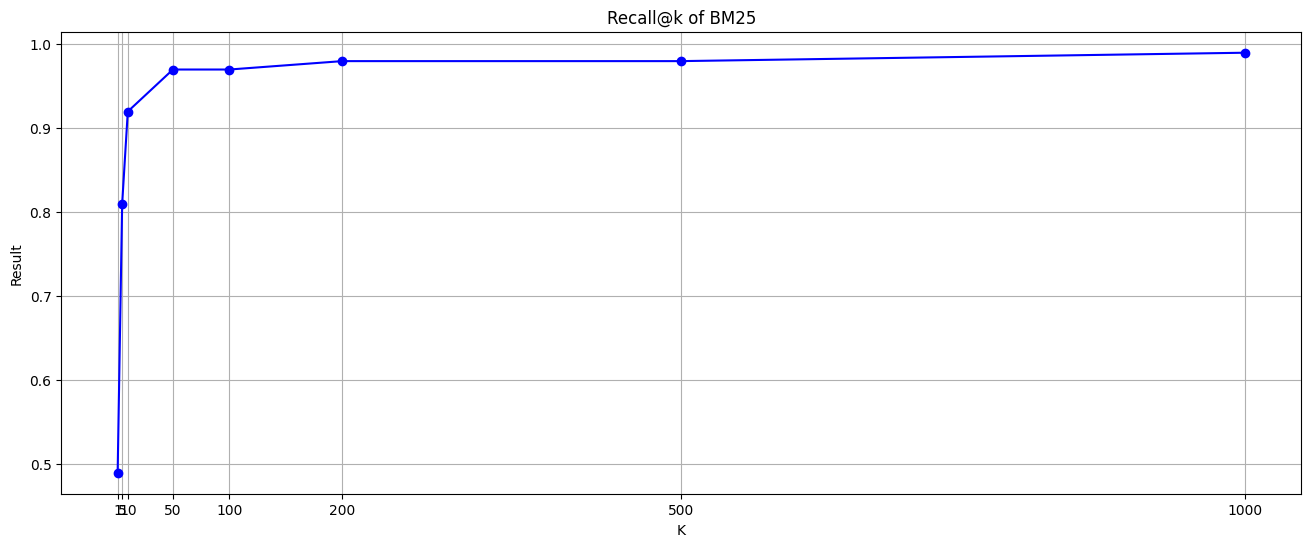

In [50]:
#결과 출력 및 시각화를 진행합니다.
for k, recall in average_recall.items():
    print(f"Recall@{k}: {recall:.4f}")

plt.figure(figsize=(16, 6))
plt.plot(list(average_recall.keys()), list(average_recall.values()), marker='o', linestyle='-', color='b')

plt.title('Recall@k of BM25')
plt.xlabel('K')
plt.ylabel('Result')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [51]:
#최종 결과를 저장합니다
with open(f"{args.SAVE_PATH}/{args.PRED_SAVE_NAME}", 'w') as f:
    json.dump(result, f)

with open(f"{args.SAVE_PATH}/{args.METRIC_SAVE_NAME}", 'w') as f:
    json.dump(average_recall, f)